<a href="https://www.kaggle.com/code/mhassaanbutt/disaster-classification-using-eat?scriptVersionId=199900088" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
!pip install tensorflow-addons
!pip install tensorflow==2.15.1
!pip install keras==2.15

# Importing Libraries 

In [3]:
import shutil,os, cv2, gc
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import metrics
import itertools
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

2024-10-07 15:57:05.332098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 15:57:05.332146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 15:57:05.333583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

# Global Variables

In [4]:
data_dir  = '/kaggle/input/aiderdata/AIDER/' #dataset_path
SEED = 68765
input_shape=(224, 224, 3)
num_classes=len(os.listdir(data_dir))
train_ratio=0.80    # 70% for training
val_ratio=0.10     # 15% for validation
test_ratio=0.10 
num_epochs = 50
batch_size = 24
patch_size = 4  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
learning_rate = 0.001
weight_decay = 0.0001
label_smoothing = 0.1
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 4 X 4 = 16 
Patches per image: 3136


**Ensure the output directory exists**

In [5]:
output_dir = f'results/epoches_{num_epochs}_batch_size_{batch_size}_train_{train_ratio*100}%'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Setting GPU device 

In [6]:
def set_gpu_devices():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Set memory growth on all GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                
            # If you want to use all GPUs, set them as visible
            tf.config.experimental.set_visible_devices(gpus, 'GPU')
            
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs')
        except RuntimeError as e:
            print(e)

# Call this function before any TensorFlow operations
set_gpu_devices()

2 Physical GPUs, 2 Logical GPUs


**Note: In case you have more than one GPU for training**

In [7]:
# Set up the mirrored strategy for using multiple GPUs
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of devices: 2


# Data Loader

In [8]:
class ImageDataLoader:
    def __init__(self, data_dir, img_height=224, img_width=224, 
                 train_split=0.7, val_split=0.15, test_split=0.15, seed=42):
        self.data_dir = data_dir
        self.img_height = img_height
        self.img_width = img_width
        self.train_split = train_split
        self.val_split = val_split
        self.test_split = test_split
        self.seed = seed
        
        # Verify that splits sum to 1
        total_split = self.train_split + self.val_split + self.test_split
        if not np.isclose(total_split, 1.0):
            raise ValueError(f"Split ratios must sum to 1, got {total_split}")
        
        self.class_names = self._get_class_names()
        self.num_classes = len(self.class_names)
    
    def _get_class_names(self):
        return sorted([d for d in os.listdir(self.data_dir) 
                      if os.path.isdir(os.path.join(self.data_dir, d))])
    
    def _load_and_preprocess_image(self, image_path):
        img = Image.open(image_path)
        img = img.resize((self.img_width, self.img_height))
        return np.array(img) / 255.0
    
    def load_data(self):
        images = []
        labels = []
        
        for class_idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.data_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    img_array = self._load_and_preprocess_image(img_path)
                    images.append(img_array)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
        
        X = np.array(images)
        y = np.array(labels)
        
        # One-hot encode the labels
        y = to_categorical(y, num_classes=self.num_classes)
        
        # First split: separate training set
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, 
            train_size=self.train_split, 
            random_state=self.seed, 
            stratify=np.argmax(y, axis=1)  # Use original labels for stratification
        )
        
        # Second split: divide remaining data into validation and test sets
        val_ratio = self.val_split / (self.val_split + self.test_split)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            train_size=val_ratio,
            random_state=self.seed,
            stratify=np.argmax(y_temp, axis=1)  # Use original labels for stratification
        )
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def get_tf_dataset(self, batch_size=32):
        X_train, X_val, X_test, y_train, y_val, y_test = self.load_data()
        
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
            .shuffle(1000).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
        test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
        
        return train_ds, val_ds, test_ds

## Initialize the data loader with custom splits

In [9]:
data_loader = ImageDataLoader(
    data_dir,
    train_split=train_ratio,    # 70% for training
    val_split=val_ratio,     # 15% for validation
    test_split=test_ratio     # 15% for testing
)

# Load the data
X_train, X_val, X_test, y_train, y_val, y_test = data_loader.load_data()

print(f"Training set shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Number of classes: {data_loader.num_classes}")

Training set shape: (4503, 224, 224, 3)
Training labels shape: (4503, 5)
Number of classes: 5


# EAT Architecture

## 1. Implement the patch extraction and encoding layer

In [10]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

## 2.Implement the external attention block

In [11]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

## 3. Implement the MLP block

In [12]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

## 4. Implement the Transformer block

In [13]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

## 5. Implement the EANet model

In [14]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # x = data_augmentation(inputs)
    # Extract patches directly from inputs
    x = PatchExtract(patch_size)(inputs) # pass x instead of inputs if you want to apply data_augmentation
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )
    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(data_loader.num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## 6. Model Fitting

In [15]:
with strategy.scope():
    model = get_model(attention_type="external_attention")

    model.compile(
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        optimizer=tfa.optimizers.AdamW(
            learning_rate=learning_rate, weight_decay=weight_decay
        ),
        metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
    )

    # Train the model and save the history
    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_val, y_val)
    )

# Save training history as JSON
history_dict = history.history
history_file_path = os.path.join(output_dir, "training_history.json")

Epoch 1/50
141/141 [==============================] - 86s 409ms/step - loss: 1.2384 - accuracy: 0.6671 - val_loss: 1.1400 - val_accuracy: 0.6238
Epoch 2/50
141/141 [==============================] - 52s 370ms/step - loss: 0.9920 - accuracy: 0.7064 - val_loss: 0.9882 - val_accuracy: 0.6964
Epoch 3/50
141/141 [==============================] - 52s 370ms/step - loss: 0.9118 - accuracy: 0.7431 - val_loss: 0.9182 - val_accuracy: 0.7544
Epoch 4/50
141/141 [==============================] - 52s 370ms/step - loss: 0.8744 - accuracy: 0.7617 - val_loss: 0.9082 - val_accuracy: 0.7803
Epoch 5/50
141/141 [==============================] - 52s 370ms/step - loss: 0.8098 - accuracy: 0.7930 - val_loss: 0.8445 - val_accuracy: 0.8041
Epoch 6/50
141/141 [==============================] - 52s 370ms/step - loss: 0.7601 - accuracy: 0.8248 - val_loss: 0.8076 - val_accuracy: 0.8228
Epoch 7/50
141/141 [==============================] - 52s 368ms/step - loss: 0.7475 - accuracy: 0.8294 - val_loss: 0.8343 - val_ac

NameError: name 'json' is not defined

# Results Visulaztions

## Let's visualize the training progress of the model

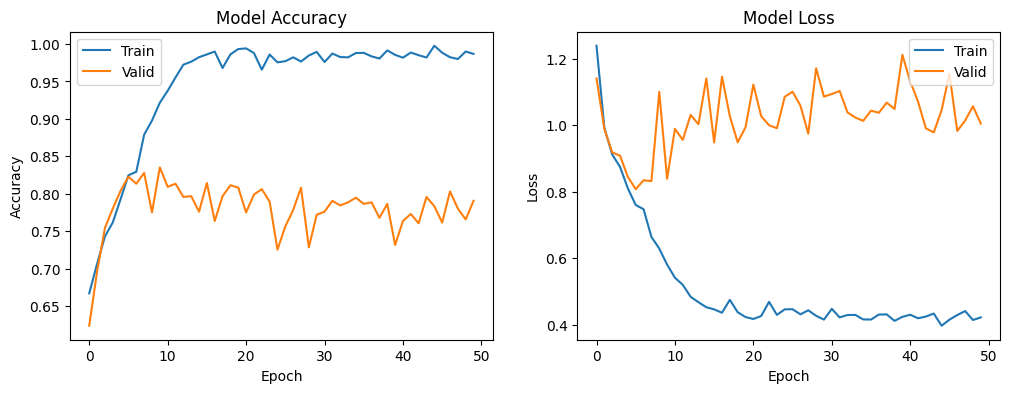

In [21]:
import json
# Plot training performance
plt.rcParams["figure.figsize"] = (15, 8)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Valid'], loc='upper left')

# Plot loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Valid'], loc='upper right')

# Save the figure
output_path = os.path.join(output_dir, 'accuracy_loss_plots.png')
plt.savefig(output_path, dpi=500)
plt.show()

# Save history to JSON file
history_dict = {}
for epoch in range(len(history.history['accuracy'])):
    history_dict[epoch] = {
        "accuracy": history.history['accuracy'][epoch],
        "val_accuracy": history.history['val_accuracy'][epoch],
        "loss": history.history['loss'][epoch],
        "val_loss": history.history['val_loss'][epoch]
    }

with open(history_file_path, 'w') as f:
    json.dump(history_dict, f, indent=4)

## Let's display the final results of the test

In [23]:
loss, accuracy= model.evaluate(X_val, y_val)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

31/31 [==============================] - 4s 131ms/step - loss: 1.0045 - accuracy: 0.7907
Test loss: 1.0
Test accuracy: 79.07%


## Prediction

In [25]:
Y_pred = model.predict(X_val)

31/31 [==============================] - 10s 133ms/step


In [26]:
print('Model Accuracy score', accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1)))

Model Accuracy score 0.7906735751295336


# Performance Metrics

In [ ]:
import gc
import numpy as np
from tqdm import tqdm

tta_steps = 10  # Number of Test-Time Augmentations
predictions = []

# Loop through TTA steps
for i in tqdm(range(tta_steps)):
    preds = model.predict(X_test, batch_size=batch_size, verbose=1)
    predictions.append(preds)
    
    # Free up memory after each iteration
    gc.collect()

# Averaging the predictions over all TTA steps
Y_pred_tta = np.mean(predictions, axis=0)

## Confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(10,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('ETA_Confusion_Matrix.png', dpi=500)
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['Collapsed Building', 'Fire', 'Flooded Areas', 'Normal', 'Traffic Incident']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

## Classification Report

In [ ]:
# Calculate the classification report
report = classification_report(
    np.argmax(y_test, axis=1),
    np.argmax(Y_pred_tta, axis=1)
)

# Print the classification report
print("Classification Report:")
print(report)

## ROC Curves

In [ ]:
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('ETA_ROC_Curve.png', dpi=500)
plt.show()
plt.close()

## Conclusions

**It is remarkable to see the success of deep learning in such varied real world problems. We have demonstrated how to classify different disaster types from a collection of different modility images using External Attention Transformer.**